# Impedance or reflectivity

Trying to see how to combine G with a derivative operator to get from the impedance model to the data with one forward operator.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from utils import plot_all
%matplotlib inline

In [5]:
from scipy import linalg as spla

def convmtx(h, n):
    """
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    """
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)

## Construct the model m

In [43]:
# Impedance, imp     VP    RHO
imp = np.ones(50) * 2550 * 2650
imp[10:15] =  2700 * 2750
imp[15:27] =  2400 * 2450
imp[27:35] =  2800 * 3000

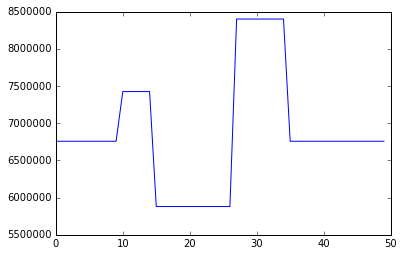

In [44]:
plt.plot(imp)

But I really want to use the reflectivity, so let's compute that:

In [80]:
D = convmtx([-1, 1], imp.size)[:, :-1]

In [81]:
D

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [88]:
r = D @ imp

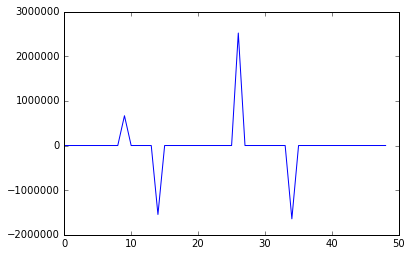

In [89]:
plt.plot(r[:-1])

I don't know how best to control the magnitude of the coefficients or how to combine this matrix with G, so for now we'll stick to the model `m` being the reflectivity, calculated the normal way.

In [75]:
m = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

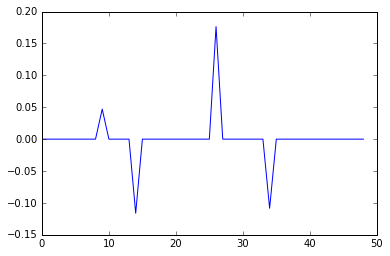

In [76]:
plt.plot(m)

## Forward operator: convolution with wavelet

Now we make the kernel matrix *G*, which represents convolution.

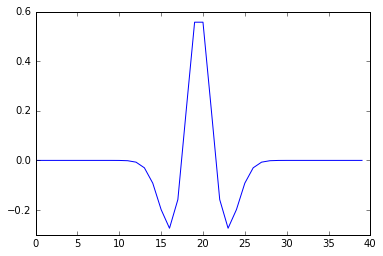

In [77]:
from scipy.signal import ricker
wavelet = ricker(40, 2)

plt.plot(wavelet)

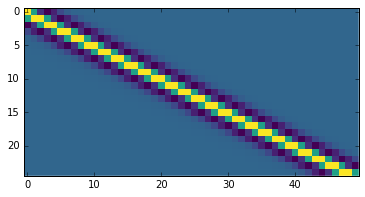

In [78]:
# Downsampling: set to 1 to use every sample.
s = 2

# Make G.
G = convmtx(wavelet, m.size)[::s, 20:70]
plt.imshow(G, cmap='viridis', interpolation='none')

In [79]:
# Or we can use bruges (pip install bruges)
# from bruges.filters import ricker
# wavelet = ricker(duration=0.04, dt=0.001, f=100)
# G = convmtx(wavelet, m.size)[::s, 21:71]

# f, (ax0, ax1) = plt.subplots(1, 2)
# ax0.plot(wavelet)
# ax1.imshow(G, cmap='viridis', interpolation='none', aspect='auto')

## Forward model the data d

Now we can perform the forward problem: computing the data.

In [16]:
d = G @ m

Let's visualize these components for fun...

In [113]:
def add_subplot_axes(ax, rect, axisbg='w'):
    """
    Facilitates the addition of a small subplot within another plot.

    From: http://stackoverflow.com/questions/17458580/
    embedding-small-plots-inside-subplots-in-matplotlib

    License: CC-BY-SA

    Args:
        ax (axis): A matplotlib axis.
        rect (list): A rect specifying [left pos, bot pos, width, height]
    Returns:
        axis: The sub-axis in the specified position.
    """
    def axis_to_fig(axis):
        fig = axis.figure

        def transform(coord):
            a = axis.transAxes.transform(coord)
            return fig.transFigure.inverted().transform(a)

        return transform

    fig = plt.gcf()
    left, bottom, width, height = rect
    trans = axis_to_fig(ax)
    x1, y1 = trans((left, bottom))
    x2, y2 = trans((left + width, bottom + height))
    subax = fig.add_axes([x1, y1, x2 - x1, y2 - y1])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2] ** 0.5
    y_labelsize *= rect[3] ** 0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


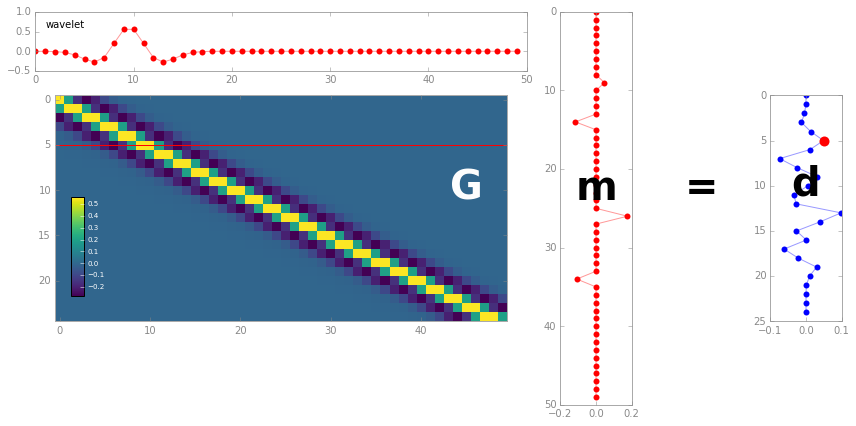

In [119]:
from matplotlib import gridspec, spines

fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(5, 8) 

# Set up axes.
axw = plt.subplot(gs[0, :5])   # Wavelet.
axg = plt.subplot(gs[1:4, :5]) # G
axm = plt.subplot(gs[:, 5])    # m
axe = plt.subplot(gs[:, 6])    # =
axd = plt.subplot(gs[1:4, 7])    # d

cax = add_subplot_axes(axg, [-0.08, 0.05, 0.03, 0.5])

params = {'ha': 'center', 
          'va': 'bottom',
          'size': 40,
          'weight': 'bold',
         }

axw.plot(G[5], 'o', c='r', mew=0)
axw.plot(G[5], 'r', alpha=0.4)
axw.locator_params(axis='y', nbins=3)
axw.text(1, 0.6, "wavelet", color='k')

im = axg.imshow(G, cmap='viridis', aspect='1', interpolation='none')
axg.text(45, G.shape[0]//2, "G", color='w', **params)
axg.axhline(5, color='r')
plt.colorbar(im, cax=cax)

y = np.arange(m.size)
axm.plot(m, y, 'o', c='r', mew=0)
axm.plot(m, y, c='r', alpha=0.4)
axm.text(0, m.size//2, "m", color='k', **params)
axm.invert_yaxis()
axm.locator_params(axis='x', nbins=3)

axe.set_frame_on(False)
axe.set_xticks([])
axe.set_yticks([])
axe.text(0.5, 0.5, "=", color='k', **params)

y = np.arange(d.size)
axd.plot(d, y, 'o', c='b', mew=0)
axd.plot(d, y, c='b', alpha=0.4)
axd.plot(d[5], y[5], 'o', c='r', mew=0, ms=10)
axd.text(0, d.size//2, "d", color='k', **params)
axd.invert_yaxis()
axd.locator_params(axis='x', nbins=3)

for ax in fig.axes:
    ax.xaxis.label.set_color('#888888')
    ax.tick_params(axis='y', colors='#888888')
    ax.tick_params(axis='x', colors='#888888')
    for child in ax.get_children():
        if isinstance(child, spines.Spine):
            child.set_color('#aaaaaa')

# For some reason this doesn't work...
for _, sp in cax.spines.items():
    sp.set_color('w')

# But this does...
cax.xaxis.label.set_color('#ffffff')
cax.tick_params(axis='y', colors='#ffffff')
cax.tick_params(axis='x', colors='#ffffff')

fig.tight_layout()
plt.show()

Note that `G * m` gives us exactly the same result as `np.convolve(w_, m)`. This is just another way of implementing convolution that lets us use linear algebra to perform the operation, and its inverse.

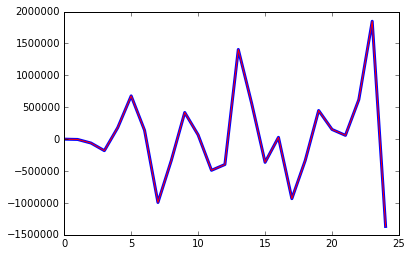

In [91]:
plt.plot(np.convolve(wavelet, m, mode='same')[::s], 'blue', lw=3)
plt.plot(G @ m, 'red')